## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
z_score = lambda x : (x-np.mean(x,axis=0))/ np.std(x,axis=0) #code from exercise 5

## Variables and df loading

In [4]:
col = 'tab10' #colour theme

df = pd.read_csv(TRAIN) #training dataframe

attributes = list(df.columns)[:-1] #creates list of column names for later, without the class

X = df[attributes].copy() #attributes
y = df['type'].copy() #true values
df['type_desc'] = ''
y_types = {1:'wind_float', 2:'wind_non', 3:'wind_veh', 5:'container', 6:'tableware', 7:'headlamp'}
y_list = y.unique() #'y' values

X_std = z_score(X) #standardizes X as later we see they are on different scales

for i in y_list: #this changes the 'type' to a descriptive word rather than a number
    #This is more human readable for plotting later - 'y' is still using the numbers
    df['type_desc'][df['type'] == i] = y_types[i]
    
df.head(3)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type,type_desc
0,1.51839,12.85,3.67,1.24,72.57,0.62,8.68,0.0,0.35,2,wind_non
1,1.52081,13.78,2.28,1.43,71.99,0.49,9.85,0.0,0.17,2,wind_non
2,1.51708,13.72,3.68,1.81,72.06,0.64,7.88,0.0,0.00,2,wind_non


In [5]:
def Gini(g_df, y,threshold):
    '''Takes a threshold and calc the Gini impurity of each split of the given df'''
    g_df = pd.concat([g_df,y], axis=1,)
    g_df.columns=['Att', 'class']
    #print(df.head())
    
    class_count = np.zeros((8), dtype=int)
    for i in range(len(g_df)):
        class_count[g_df['class'].iloc[i]]+=1        
    class_count = np.delete(class_count, [0,4])
    #print(class_count)

    proportion = [class_count[i]/np.sum(class_count) for i in range(len(class_count))]
    #print([round(i,3) for i in proportion])
    node_gini = 0
    for i in range(len(proportion)):
        node_gini += proportion[i]*(1-proportion[i])  
    
    df_a = g_df[g_df['Att'] < threshold]
    df_b = g_df[g_df['Att'] >= threshold]
    
    n = g_df.shape[0]
    n_a = df_a.shape[0]
    n_b = df_b.shape[0]
    
    
    #calc and return gini impurity for each side
    #print(len(df_a))
    #print(len(df_b))
    gini_a = 0
    gini_b = 0
    
    for i in y_list: #loop through all classes
        
        k_a = df_a[df_a['class'] == i] 
        p_ka = len(k_a)/len(df_a) #count number of class k in first split, divided by total in that split.
        
        k_b = df_b[df_b['class'] == i]
        p_kb = len(k_b)/len(df_b) #count number of class k in first split, divided by total in that split.
        
        #print(i, k_a,k_b)
        
        gini_a += (p_ka* (1-p_ka)) #p*(1-p)
        gini_b += (p_kb* (1-p_kb)) #p*(1-p)
        

    #print(round(gini_a, 3), round(gini_b, 3)) #The leaves gini scores are correct!
    
    return (n_a/n)*gini_a + (n_b/n)*gini_b, node_gini #weighted gini from leaves != overall node gini

        
        
Gini(df['Ba'],y, 0.4) #0.736

(0.6199065196548418, 0.7355524525922255)

In [6]:
def leaf_hunter(df):
    '''takes df and class returns best weighted leaf gini scores, best threshold, 
    best attribute and node gini score'''
    #So many dratted loops! 
    best_gini = 1
    best_class = ''
    best_threshold = ''
    best_att = ''
    for a in attributes: #loop through attributes
        tmp = df.sort_values(by=a, axis=0).copy()
        
        for threshold in range(len(df)-1): #loop through potential thresholds
            
            if tmp[a].iloc[threshold] != tmp[a].iloc[threshold+1]: #skip if the two points are the same value
                thresh = ((tmp[a].iloc[threshold] + tmp[a].iloc[threshold+1])/2)
                #print((tmp[a].iloc[threshold], tmp[a].iloc[threshold+1]), thresh)       
                gini, node_gini = Gini(df[a], df['type'], thresh)
                
                if gini < best_gini:
                    best_gini = gini
                    best_threshold = thresh
                    best_att = a
                
                
    return best_gini, best_threshold, best_att, node_gini


            
best_gini, best_threshold, best_att, node_gini = leaf_hunter(df)

print(best_gini, best_threshold, best_att, node_gini)

0.6199065196548418 0.4 Ba 0.7355524525922255


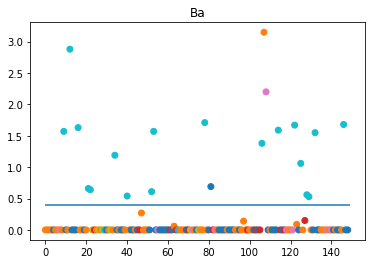

In [7]:
plt.scatter([i for i in range(149)], df[best_att], c=y, cmap=col)
plt.hlines(best_threshold, 0, 149)
plt.title(f'{best_att}');

In [8]:
clf = DecisionTreeClassifier(max_depth=2)
model = clf.fit(X, y)

[(0, 'RI'), (1, 'Na'), (2, 'Mg'), (3, 'Al'), (4, 'Si'), (5, 'K'), (6, 'Ca'), (7, 'Ba'), (8, 'Fe')]


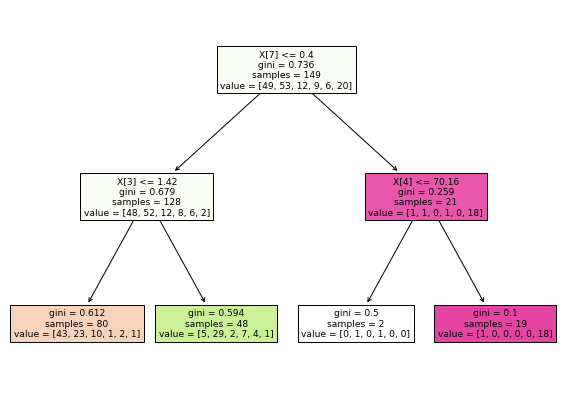

In [9]:
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(model, filled= True)
print([(i, attributes[i]) for i in range(len(attributes))])

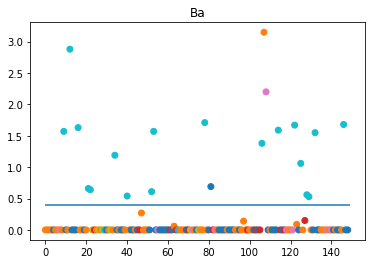

In [10]:
plt.scatter([i for i in range(149)], df['Ba'], c=y, cmap=col)
plt.hlines(0.4, 0, 149)
plt.title('Ba');

128 21
0.6050781249999999 1.42 Al 0.67919921875


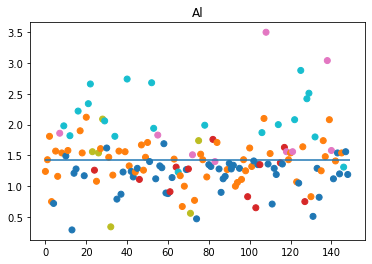

In [11]:
a_df = df[df[best_att] < best_threshold].copy()
b_df = df[df[best_att] >= best_threshold].copy()
print(a_df.shape[0], b_df.shape[0])

best_gini, best_threshold, best_att, node_gini = leaf_hunter(a_df)

print(best_gini, best_threshold, best_att, node_gini)

plt.scatter([i for i in range(149)], df[best_att], c=y, cmap=col)
plt.hlines(best_threshold, 0, 149)
plt.title(f'{best_att}');

0.1378446115288221 70.16 Si 0.2585034013605442


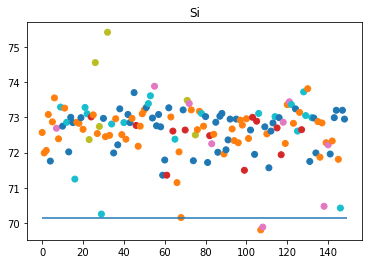

In [12]:
best_gini, best_threshold, best_att, node_gini = leaf_hunter(b_df)

print(best_gini, best_threshold, best_att, node_gini)

plt.scatter([i for i in range(149)], df[best_att], c=y, cmap=col)
plt.hlines(best_threshold, 0, 149)
plt.title(f'{best_att}');